In [15]:
import os

import pandas as pd
import numpy as np

from scipy import stats

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

%config Completer.use_jedi = False

In [3]:
import cufflinks as cf
cf.go_offline()

### Read In Data

In [4]:
requests_df = pd.read_pickle('.\Silver Data\silver_requests.pkl')
quotes_df = pd.read_pickle('.\Silver Data\silver_quotes.pkl')

### Analysis for Conversion

Goal: to determine what factors increase (or impact in general whether positive or negative) chances that a request turns into an order

Step...

1. Merge data into one dataframe to consolidate one-to-many relationship of requests and quotes. Also create subset where status = "ordered"

In [5]:
merged_df = pd.merge(requests_df, quotes_df, on='Request UUID', how='left')

In [6]:
conversion_df = merged_df[merged_df['Status'] == 'Ordered']

2. Determine initial set of features which can influence conversion logically

In [7]:
# Create a binary column of converted or not
merged_df['Converted'] = 0
merged_df.loc[merged_df['Status']=='Ordered','Converted'] = 1

In [8]:
def fetch_numeric_vars(df):
    """
    Return the columns that are number-like in nature as explanatory variables.

    ...for further analysis where there are binary/categoric explanatory vars, then we would employ some kind of one-hot encoding or rep.
    """
    numeric_columns = [col for col, dtype in df.dtypes.items() if pd.api.types.is_numeric_dtype(dtype)]

    return numeric_columns

In [9]:
# first determine numeric columns
numeric_variables = fetch_numeric_vars(merged_df)
numeric_variables

['Current Unit Price',
 'Target Unit Price',
 'Quote Unit Price',
 'Quote Delay',
 'Converted']

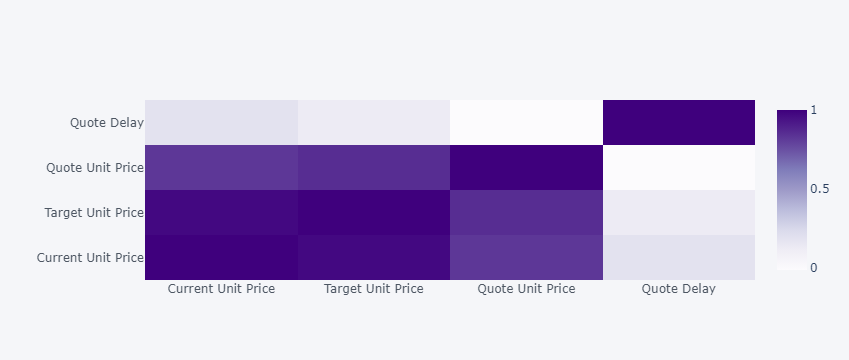

In [14]:
# Obvious observations here. Showing how certain products correlate in price, and how buyers tend to quote close to current price
conversion_df[numeric_variables[:-1]].corr().iplot(kind='heatmap',colorscale='purples')

3. Perform t-test GENERALLY: those who converted and didn't

In [18]:
conversion_df = merged_df.loc[merged_df['Converted']==1]
non_conversion_df = merged_df.loc[merged_df['Converted']==0]

In [36]:
# dictionary to store t-test results
t_test_results = {}

for col in numeric_variables[:-1]:
    t_statistic, p_value = stats.ttest_ind(conversion_df[col].fillna(0.0), non_conversion_df[col].fillna(0.0), equal_var=False)
    t_test_results[col] = {'t_statistic': t_statistic, 'p_value': p_value}

In [37]:
t_test_results

{'Current Unit Price': {'t_statistic': 2.82214902915681,
  'p_value': 0.0062875833515464},
 'Target Unit Price': {'t_statistic': 2.270091637614785,
  'p_value': 0.026177293608147887},
 'Quote Unit Price': {'t_statistic': -0.01654602739835923,
  'p_value': 0.9868411968019684},
 'Quote Delay': {'t_statistic': -2.134562969735299,
  'p_value': 0.0357484657760908}}

The above indicates a rejection of the null hypothesis; that there is a statistically significant difference between requests that converted to order and those that didn't. This is true for:

- Current Unit Price
- Target Unit Price
- Quote Delay

...based on p-values from the t-test

3.5 Perform the t-test SPECIFICALLY: those who converted and those who declined

In [38]:
merged_df['Status'].unique()

array([nan, 'Available', 'Declined', 'Expired', 'Ordered'], dtype=object)

In [39]:
# conversion_df as normal
declined_conversion_df = merged_df.loc[merged_df['Status']=="Declined"]

In [40]:
# dictionary to store t-test results
t_test_results_2 = {}

for col in numeric_variables[:-1]:
    t_statistic, p_value = stats.ttest_ind(conversion_df[col].fillna(0.0), declined_conversion_df[col].fillna(0.0), equal_var=False)
    t_test_results_2[col] = {'t_statistic': t_statistic, 'p_value': p_value}

In [41]:
t_test_results_2

{'Current Unit Price': {'t_statistic': 0.6123956712024555,
  'p_value': 0.546748587081374},
 'Target Unit Price': {'t_statistic': 1.7355410668470124,
  'p_value': 0.09246177336147934},
 'Quote Unit Price': {'t_statistic': -1.7138881709943468,
  'p_value': 0.10416506983584559},
 'Quote Delay': {'t_statistic': -1.9480179522075325,
  'p_value': 0.06833464212789603}}

The above indicates no solid rejection of the null hypothesis (based on an alpha of 0.05). Though few variables make it close. This is true for:

- Target Unit Price
- Quote Delay

...based on p-values from the t-test

#### Observation

This (coupled with the general t-test run previously) may suggest that these overlapping variables have an impact on whether or not requests convert eventually to an order. 

The conclusion I would draw being that reasonable price requests from the buyer, and timely quote submission from the supplier, lead to an increased likelihood to convert.

# Further Analysis POI:

The below are further steps I would take (time-allowing) to uncover better patterns of the data

- Performing a logistic regression with several engineered columns for further insight. Including (but not limited to):
- - deltas in prices and how their magnitudes impact results
  - counts on the number of requests and quotes (to show if abundance of choice impacts the buyer)
- Acquiring contextual data to see if seasonal pressures or market values impacted likelihoods
- - this would involve acquiring dated data for requests and quotes.
- Further insight into the qualitative columns as opposed to just the numeric columns.

#### * PLEASE SEE ATTACHED WORD DOC FOR DETAILS ABOUT INSIGHTS

In [44]:
requests_df

,_id,Request UUID,Request Name,Request Category,Current Unit Price,Target Unit Price,Supply Priority
0,666ade13e6cdb11d64642be2,2a0c4e3e-ad49-4963-8b4d-cd7bc2178265,Dried leaves of Tulsi Vana - Ocimum gratissimum.,"Herbs, Spices & Seasonings",10.00,10.00,Quality
1,666ade13e6cdb11d64642be3,3f37c3c6-fd5e-4fb1-b61d-544a7e5fbd30,Fava Bean Protein Isolate 90%,Additives & Preservatives,6.00,3.00,Price
3,666ade13e6cdb11d64642be5,4898a734-29ae-4b06-b478-1d64833095a5,inulin,Additives & Preservatives,4.50,4.50,NaN
4,666ade13e6cdb11d64642be6,6bde3425-a303-409b-8aff-69437c204f4c,Organic Peruvian Cacao Nibs,"Nuts, Seeds & Dried Fruit",1.00,0.01,Price
5,666ade13e6cdb11d64642be7,290b221d-48a9-4a89-a54d-c6bb7afb8e4a,Peruvian Cocoa Butter Wafers,"Fats, Oils & Vinegars",0.01,0.01,Price
...,...,...,...,...,...,...,...
505,666ade13e6cdb11d64642ddb,6f39a515-609d-4a45-a77a-9e233cffb2aa,Cassava Flour (organic),Fresh Fruit & Vegetables,3.90,2.00,NaN
507,666ade13e6cdb11d64642ddd,de2b75d4-d09b-4830-b7b5-8dad4cbb748c,Tabasco Seasoning,"Herbs, Spices & Seasonings",11.40,11.20,NaN
508,666ade13e6cdb11d64642dde,62266ce5-c4b2-4cf2-af7a-e99a2a860223,British Silverside Beef,Meat & Meat Alternatives,6.20,5.40,NaN
509,666ade13e6cdb11d64642ddf,f426764f-8c18-4cac-bb96-4decdf21c678,Himalayan salt fine,"Herbs, Spices & Seasonings",0.40,0.40,NaN
